<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Lab-2/Linde-Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Linde van Beers**

# **Abstract**

This short report explores a simulation a fluid flow, and the effect of Reynold's number on steadiness of the flow, Strouhal number, drag coefficient and lift coefficient. We find that for large Reynold's numbers vortex shredding takes place.

# **About the code**

In [406]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$


# **Method**

**Define domain and mesh**

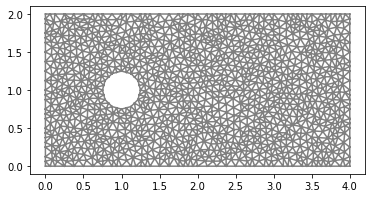

In [408]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.25

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [0]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

We calculate the Reynold's number using $Re = \frac{UD}{\nu}$. We want to compare simulations for Reynolds numbers $Re = 1, 10, 100, 1000$. We vary the Reynold's number by varying the viscosity $\nu$. 

We keep the diamater of the cylinder (i.e. the characteristinc length scale $D$) constant at $0.5$ and $U$ constant at 1. Therefore we use $\nu = 0.5, 0.05, 0.005, 0.0005$ respectively to achieve the desired Reynold's numbers. 

In [0]:
# Set viscosity
nu = 0.005

**Define method parameters**

In [0]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

In [0]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

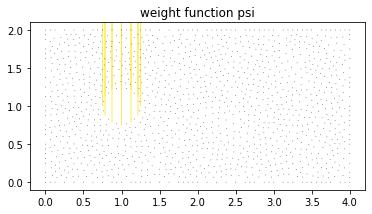

In [414]:
# Define the direction of the force to be computed 
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

plt.figure()
plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [0]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.0323523806378151


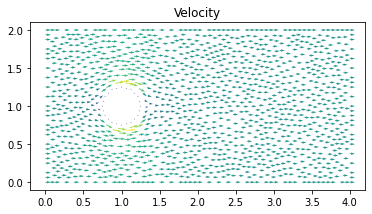

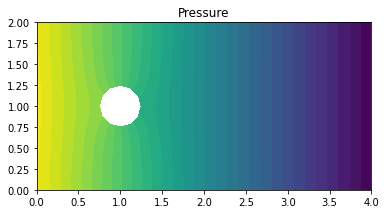

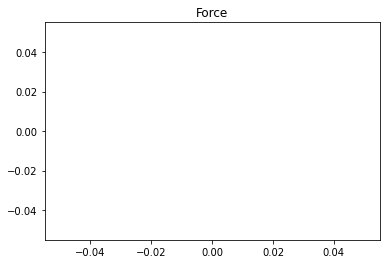

Time t = 3.0087713993168035


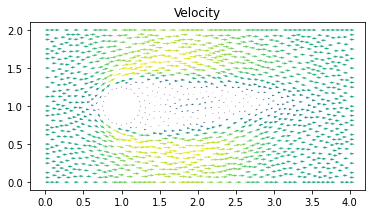

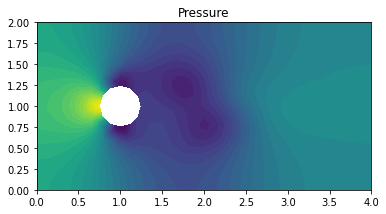

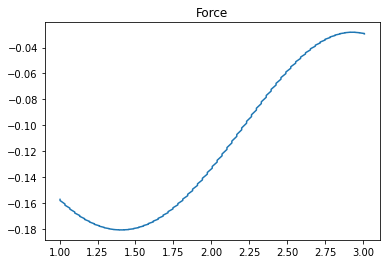

Time t = 6.017542798633597


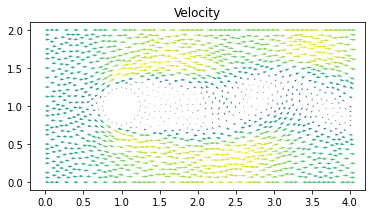

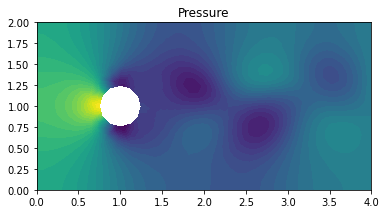

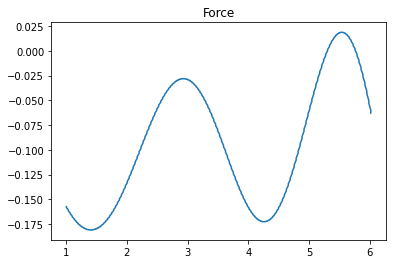

Time t = 9.026314197950418


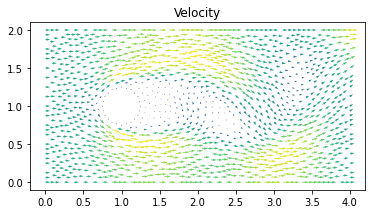

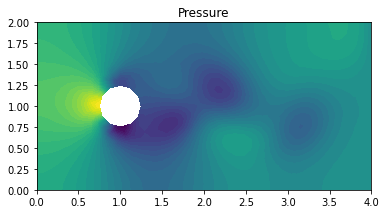

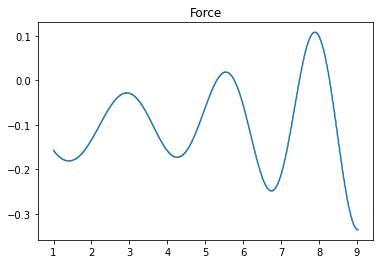

Time t = 12.002733216629478


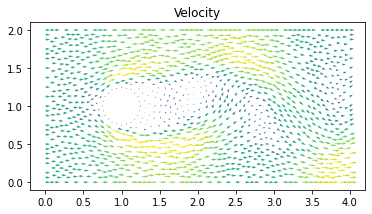

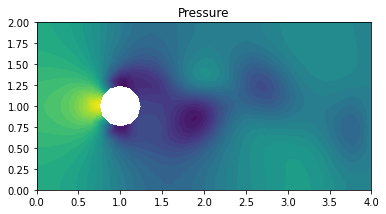

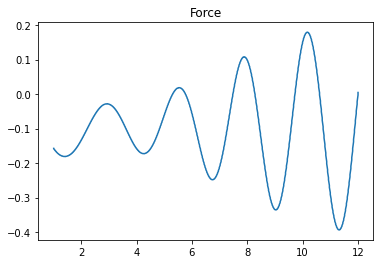

Time t = 15.011504615946354


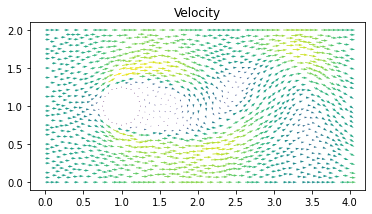

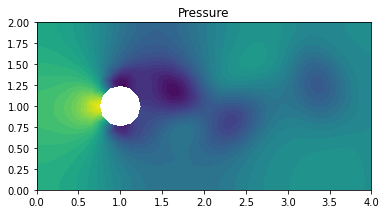

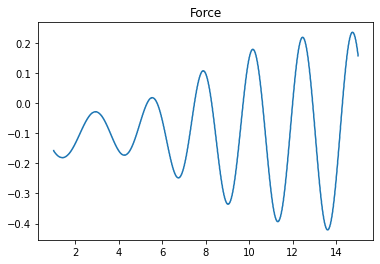

Time t = 18.020276015263118


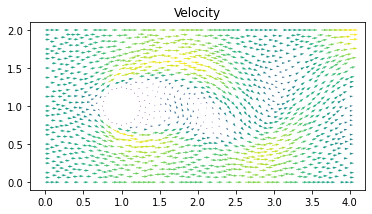

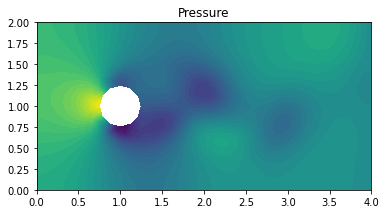

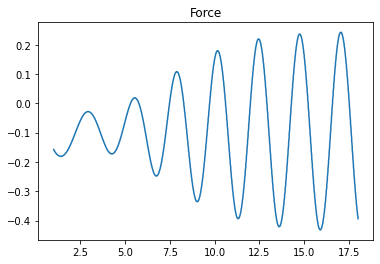

Time t = 21.02904741457983


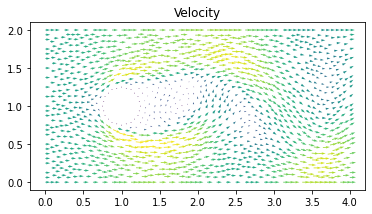

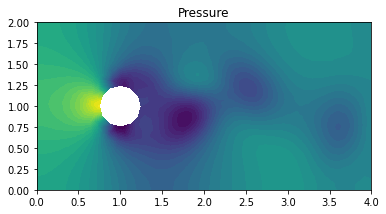

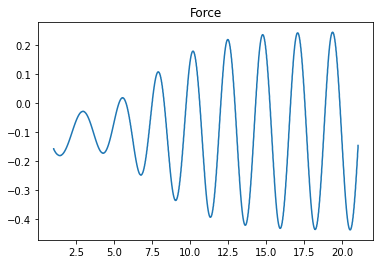

Time t = 24.005466433258725


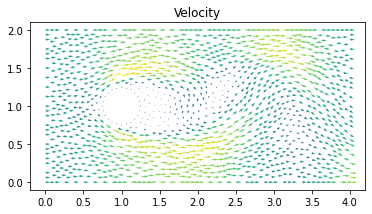

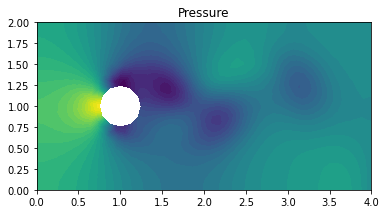

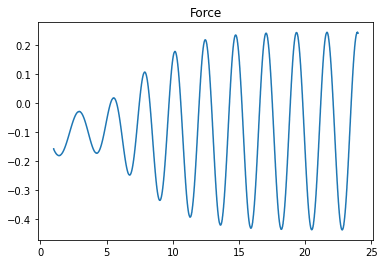

Time t = 27.014237832575436


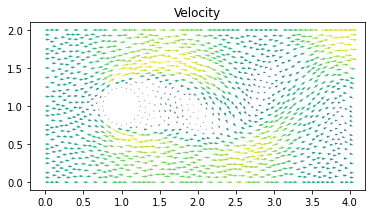

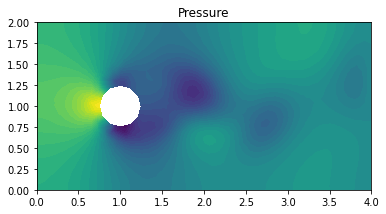

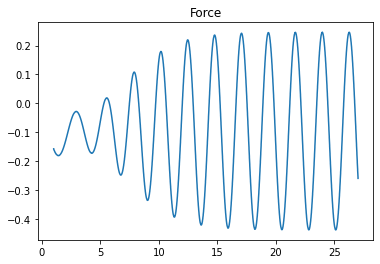

In [416]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

# !tar -czvf results-NS.tar.gz results-NS
# files.download('results-NS.tar.gz')

**Steady vs unsteady flow**

A steady flow implies that the properties of velocity and pressure of the fluid do not change over time. We can inspect this by looking at the graphs of said properties as time progresses and see if they change. We disregard the first graph, since this is the initialisation. 

* For $Re = 1$ we have a steady flow, since the velocity and pressure graphs are identical for all time steps after the first. 
* For $Re = 10$ we again have steady flow for the same reason. 
* For $Re = 100$ we observe that the velocity and pressure graphs are different for each time step, this means that the flow is not steady. 
* For $Re = 1000$ we also see an unsteady flow. 

**Strouhal number**

The Strouhal number is defined as follows:

$Sr = \frac{fD}{U}$

Where $f$ is the frequency, $D$ the characteristic length (diameter of the circle) and $U$ the velocity of the flow.

The Strouhal number is defined for flows where vortex shredding takes place, in our case oonly for the latter two cases, whith $Re = 100, 1000$.

We find the frequency first using the results for the lift force as generated by the time stepping algorithm. In order to do this we approximate two points in time where the force is zero and the derivative is positive (l_time and r_time). We then divide the number of oscillations that have taken place in between these points by the time difference between them to find the frequency:

$f = \frac{\textrm{#oscillations}}{\textrm{r_time}-\textrm{l_time}}$

Once we have the frequency we have all necessary elements to calculate the Strouhal number. 

Frequency: 0.43415604141606984
Strouhal number: 0.21707802070803492


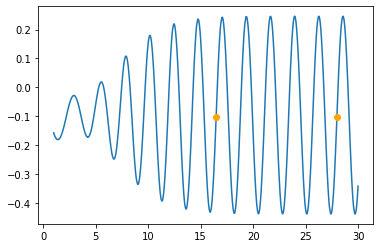

In [417]:
tops=[]
mid = np.mean(force_array[ int(len(force_array)/4):len(force_array)-1]) #(np.amax(force_array)+np.amin(force_array))/2
for i in range(len(force_array)-1,int( len(force_array)/2),-1):
  if force_array[i-1]< mid and force_array[i] > mid:
    tops.append(i)

l_time = time[tops[-1]-1] + (abs(force_array[tops[-1]-1]-mid)/(force_array[tops[-1]]-mid-force_array[tops[-1]-1]-mid))*(time[tops[-1]]-time[tops[-1]-1])
r_time = time[tops[0]-1] + (abs(force_array[tops[0]-1]-mid)/(force_array[tops[0]]-mid-force_array[tops[0]-1]-mid))*(time[tops[0]]-time[tops[0]-1])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(time, force_array, zorder = -1)
# sub.scatter(time[tops], force_array[tops])
sub.scatter([l_time,r_time], [mid,mid], c= 'orange')

freq = (len(tops)-1)/(r_time-l_time)
print('Frequency:', freq)

sr = freq*2*rc/uin
print('Strouhal number:', sr)


The results for different values of Strouhal number are:

*   $Re = 100$: $Sr \approx 0.22$
*   $Re = 1000$: $Sr \approx 0.24$


**Draft and Lift Coefficients**

The draft and lift coefficient are calculated in the following way: 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

For the Force I approximate the mean force once the oscillation has stabilised around one mean. I do this by taking the mean of the second half of the force data, i.e. mid in the code for the Strouhal number. 

$\rho$, $U$ and $D$ are constant at $1.0$, $1.0$ and $0.5$ respectively. 

In [418]:
c = 2*mid/(uin*uin*2*rc)
print(c)

-0.41351591807253446


This gives us the following results for different Reynolds numbers:

* $Re = 1$: $c_D \approx 60.8$, $c_L \approx -0.29$
* $Re = 10$: $c_D \approx 11.2$, $c_L \approx -0.077$
* $Re = 100$: $c_D \approx 4.8$, $c_L \approx -0.44$ 
* $Re = 1000$: $c_D \approx 4.3$, $c_L \approx -0.71$

**Mesh resolution**

The Strouhal number, drag and lift coefficients for a flow with $Re = 100$ for different mesh resolutions are as follows:

* Resolution 1/8: No vortex shredding, $c_D \approx 13.2 $, $c_L \approx 0.13$
* Resolution 1/16: $Sr = 0.19$, $c_D \approx 7.66$, $c_L \approx 0.60$
* Resolution 1/32: $Sr = 0.22$, $c_D \approx 4.8$, $c_L \approx -0.44$

**Extra Assignment: Movie**

Since I wasn't sure how to include a movie in this document, I uploaded the movie seperately. It displays the pressure field in the background and the velocity through the arrows, whose size and direction indicate the magnitude and direction of the flow, respectively. 

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

We indeed find a Strouhal number close to 2 for flows with vortex shredding. The Strouhal number for $Re = 1000$ may be a bit on the high side, since it is not supposed to go over 0.22, but this difference may be due to some error introduced by computations and approximations. 

My results for the drag coefficient were not quite as expected. I tried running the codde for $Re = 10^5$ so that I could compare the results to those for a smooth sphere of $Re = 10^5$ given on the [wikipedia page for drag coefficient](https://en.wikipedia.org/wiki/Drag_coefficient). However, my results were about a factor 10 off. This might have to do with the difference between 2D and 3D, but I am not certain. The density $\rho$ may also play a role, although the density of air (which I think is used in the wikipedia page) is not far of 1, which is used in this report. 